In [ ]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


Mounted at /content/drive


# **Popis dát**
# Náš vstupný dataset obsahuje informácie o živinách a vitamínoch obsiahnutých v potravinách.
# Stĺpce predstavujú rôzne nutričné hodnoty, ako sú energia, bielkoviny, tuky, sacharidy, vitamíny a minerály.

# **Identifikačné atribúty:**
# - *NDB_No* unikátne číslo potraviny v Národnej databáze živín
# - *Descrip* opis potraviny
<br><br>
# **Makroživiny:**
# - *Energy_kcal* energetická hodnota v kilokalóriách
# - *Protein_g* obsah bielkovín v gramoch
# - *Saturated_fats_g* obsah nasýtených tukov v gramoch
# - *Fat_g* celkový obsah tukov v gramoch
# - *Carb_g* obsah sacharidov v gramoch
# - *Fiber_g* obsah vlákniny v gramoch
# - *Sugar_g* obsah cukrov v gramoch
<br><br>
# **Vitamíny:**
# - *Calcium_mg* obsah vápnika v miligramoch
# - *Iron_mg* obsah železa v miligramoch
# - *Magnesium_mg* obsah horčíka v miligramoch
# - *Phosphorus_mg* obsah fosforu v miligramoch
# - *Potassium_mg* obsah draslíka v miligramoch
# - *Sodium_mg* obsah sodíka v miligramoch
# - *Zinc_mg* obsah zinku v miligramoch
# - *Copper_mcg* obsah medi v mikrogramoch
# - *Manganese_mg* obsah mangánu v miligramoch
# - *Selenium_mcg* obsah selénu v mikrogramoch
# - *VitC_mg* obsah vitamínu C v miligramoch


# Načítanie datasetu

V datasetu byla část dat o pár sloupců posunuta. Tyto data byla posunuta zpět na správné místo v excelu. Správný opravený excel je obsažen v odevzdaných datech. V následujících částech pracujeme už s opravenou verzí excel souboru.

In [ ]:
zip_path = 'food_ingredients.zip'
extract_dir = 'Path'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

os.listdir(extract_dir)

description_path = os.path.join(extract_dir, "description.txt")

with open(description_path, 'r', encoding='utf-8') as file:
    description_text = file.read()

description_text[:1000]

excel_path = os.path.join(extract_dir, "ingredients.xlsx")
df = pd.read_excel(excel_path)

df.head()

Unnamed: 0  Unnamed: 1 Unnamed: 2 Unnamed: 3   Unnamed: 4 Unnamed: 5  \
0         NaN         NaN        NaN        NaN          NaN        NaN   
1         NaN         NaN        NaN        NaN          NaN        NaN   
2         NaN         NaN        NaN        NaN    nutrition        NaN   
3         NaN         NaN     NDB_No    Descrip  Energy_kcal  Protein_g   
4         NaN         NaN        NaN        NaN          NaN        NaN   

         Unnamed: 6 Unnamed: 7 Unnamed: 8 Unnamed: 9  ... Unnamed: 21  \
0               NaN        NaN        NaN        NaN  ...         NaN   
1               NaN        NaN        NaN        NaN  ...         NaN   
2               NaN        NaN        NaN        NaN  ...         NaN   
3  Saturated_fats_g      Fat_g     Carb_g    Fiber_g  ...     VitC_mg   
4               NaN        NaN        NaN        NaN  ...         NaN   

  Unnamed: 22    Unnamed: 23 Unnamed: 24 Unnamed: 25 Unnamed: 26 Unnamed: 27  \
0         NaN            NaN         NaN         NaN         NaN         NaN   
1         NaN            NaN         NaN         NaN         NaN         NaN   
2         NaN            NaN         NaN         NaN         NaN         NaN   
3  Thiamin_mg  Riboflavin_mg   Niacin_mg    VitB6_mg  Folate_mcg  VitB12_mcg   
4         NaN            NaN         NaN         NaN         NaN         NaN   

  Unnamed: 28 Unnamed: 29 Unnamed: 30  
0         NaN         NaN         NaN  
1         NaN         NaN         NaN  
2         NaN         NaN         NaN  
3    VitA_mcg     VitE_mg   VitD2_mcg  
4         NaN         NaN         NaN  

[5 rows x 31 columns]

Odfiltrovanie prazdnych riadkov a stlpcov

In [ ]:
df_clean = pd.read_excel(excel_path, skiprows=4)

df_clean.dropna(axis=1, how='all', inplace=True)
df_clean.dropna(axis=0, how='all', inplace=True)
df_clean.columns
df_clean.head()
df_clean.reset_index(drop=True, inplace=True)



Některé features neměli správný typ, tak jsme je opravili na správné typy.

In [ ]:
df_clean["Magnesium_mg"] = pd.to_numeric(df_clean["Magnesium_mg"], errors='coerce')
df_clean["VitE_mg"] = pd.to_numeric(df_clean["VitE_mg"], errors='coerce')


df_clean.dtypes

NDB_No               object
Descrip              object
Energy_kcal         float64
Protein_g           float64
Saturated_fats_g    float64
Fat_g               float64
Carb_g              float64
Fiber_g             float64
Sugar_g             float64
Calcium_mg          float64
Iron_mg             float64
Magnesium_mg        float64
Phosphorus_mg       float64
Potassium_mg        float64
Sodium_mg           float64
Zinc_mg             float64
Copper_mcg          float64
Manganese_mg        float64
Selenium_mcg        float64
VitC_mg             float64
Thiamin_mg          float64
Riboflavin_mg       float64
Niacin_mg           float64
VitB6_mg            float64
Folate_mcg          float64
VitB12_mcg          float64
VitA_mcg            float64
VitE_mg             float64
VitD2_mcg           float64
dtype: object

# Filtrovanie nereálnych alebo chybných hodnôt
Ponechávajú sa len hodnoty v realistickom rozsahu (0 až max) alebo prázdne (NaN).
Hodnoty sú rozdelené podľa jednotiek: gramy, miligramy, mikrogramy.



In [ ]:
grams_cols = ['Protein_g', 'Fat_g', 'Carb_g', 'Fiber_g', 'Sugar_g', 'Saturated_fats_g']
milligrams_cols = ['Calcium_mg', 'Iron_mg', 'Magnesium_mg', 'Phosphorus_mg', 'Potassium_mg',
                   'Sodium_mg', 'Zinc_mg', 'Manganese_mg', 'Selenium_mcg', 'VitC_mg',
                   'Thiamin_mg', 'Riboflavin_mg', 'Niacin_mg', 'VitB6_mg', 'VitE_mg']
micrograms_cols = ['Copper_mcg', 'Folate_mcg', 'VitB12_mcg', 'VitA_mcg', 'VitD2_mcg']


df_filtered = df_clean.copy()

# Vzhledem k tomu, že data jsou na 100g, hodnoty překračující definovaná maxima nedávají smysl.
max_g = 100
max_mg = 100000
max_mcg = 100000000


for col in grams_cols:
    df_filtered = df_filtered[(df_filtered[col].isna()) | ((df_filtered[col] >= 0) & (df_filtered[col] <= max_g))]

for col in milligrams_cols:
    df_filtered = df_filtered[(df_filtered[col].isna()) | ((df_filtered[col] >= 0) & (df_filtered[col] <= max_mg))]

for col in micrograms_cols:
    df_filtered = df_filtered[(df_filtered[col].isna()) | ((df_filtered[col] >= 0) & (df_filtered[col] <= max_mcg))]


df_filtered.shape[0], df_clean.shape[0]

(10195, 10251)

# Explorační analýza

In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10195 entries, 0 to 10249
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NDB_No            10195 non-null  object 
 1   Descrip           10195 non-null  object 
 2   Energy_kcal       10193 non-null  float64
 3   Protein_g         10194 non-null  float64
 4   Saturated_fats_g  10193 non-null  float64
 5   Fat_g             10190 non-null  float64
 6   Carb_g            10192 non-null  float64
 7   Fiber_g           10190 non-null  float64
 8   Sugar_g           10195 non-null  float64
 9   Calcium_mg        10192 non-null  float64
 10  Iron_mg           10194 non-null  float64
 11  Magnesium_mg      10190 non-null  float64
 12  Phosphorus_mg     10193 non-null  float64
 13  Potassium_mg      10192 non-null  float64
 14  Sodium_mg         10192 non-null  float64
 15  Zinc_mg           10193 non-null  float64
 16  Copper_mcg        10193 non-null  float64
 17

# Základná štatistika

Pri vypísaní základnej statistiky je vidieť, že dáta obsahujú viaceré chyby, Negatívna kalorická hodnota je jednou z nich. Vysoké čísla u viacerých vitamínov nám predpovedajú väčší počet utlierov.

In [ ]:
df_filtered.describe().T

count        mean         std  min        25%       50%  \
Energy_kcal       10193.0  221.933574  170.832829 -1.0   87.00000  183.3130   
Protein_g         10194.0   11.288721   10.439873  0.0    2.32000    8.0400   
Saturated_fats_g  10193.0    3.375392    6.580714  0.0    0.13600    1.3300   
Fat_g             10190.0   10.353671   15.931050  0.0    0.82000    4.8100   
Carb_g            10192.0   21.526272   27.013139  0.0    0.00000    8.6750   
Fiber_g           10190.0    2.150216    4.454814  0.0    0.00000    0.4000   
Sugar_g           10195.0    6.595657   13.690081  0.0    0.00000    0.4600   
Calcium_mg        10192.0   72.646838  193.231014  0.0    8.70750   19.0000   
Iron_mg           10194.0    2.656320    5.604069  0.0    0.48000    1.3000   
Magnesium_mg      10190.0   33.396794   56.619720  0.0   10.00000   20.0000   
Phosphorus_mg     10193.0  153.845720  194.593978  0.0   36.00000  130.0000   
Potassium_mg      10192.0  270.178937  361.345666  0.0  117.00000  224.0000   
Sodium_mg         10192.0  292.866431  885.983552  0.0   31.00000   79.0000   
Zinc_mg           10193.0    1.891078    3.213397  0.0    0.23000    0.8000   
Copper_mcg        10193.0    0.176025    0.538752  0.0    0.03000    0.0790   
Manganese_mg      10192.0    0.513188    6.460747  0.0    0.00100    0.0260   
Selenium_mcg      10191.0   12.868645   27.097435  0.0    0.10000    4.3000   
VitC_mg           10190.0    8.556029   63.569043  0.0    0.00000    0.0000   
Thiamin_mg        10193.0    0.200787    0.493331  0.0    0.03000    0.0750   
Riboflavin_mg     10190.0    0.225410    0.420266  0.0    0.04300    0.1450   
Niacin_mg         10194.0    3.295135    4.601685  0.0    0.38325    1.9935   
VitB6_mg          10194.0    1.908557   15.809008  0.0    0.03700    0.1225   
Folate_mcg        10194.0   36.619256  163.194265  0.0    0.00000    7.0000   
VitB12_mcg        10193.0    1.127286    4.128773  0.0    0.00000    0.0100   
VitA_mcg          10189.0   88.875460  732.452396  0.0    0.00000    1.0000   
VitE_mg           10189.0    0.945421    4.958705  0.0    0.00000    0.1300   
VitD2_mcg         10193.0    0.341191    2.897884  0.0    0.00000    0.0000   

                       75%        max  
Energy_kcal       331.0000    902.000  
Protein_g          19.8175     88.320  
Saturated_fats_g    4.0600     95.600  
Fat_g              13.3000    100.000  
Carb_g             32.6050    100.000  
Fiber_g             2.5000     79.000  
Sugar_g             5.4800     99.800  
Calcium_mg         63.0000   7364.000  
Iron_mg             2.5800    123.600  
Magnesium_mg       30.0000    781.000  
Phosphorus_mg     215.0000   9918.000  
Potassium_mg      333.0000  16500.000  
Sodium_mg         383.0000  38758.000  
Zinc_mg             2.5900     90.950  
Copper_mcg          0.1460     15.050  
Manganese_mg        0.2300    328.000  
Selenium_mcg       21.5000   1917.000  
VitC_mg             2.7000   2732.000  
Thiamin_mg          0.2170     23.375  
Riboflavin_mg       0.2530     17.500  
Niacin_mg           4.9465    127.500  
VitB6_mg            0.3650    316.000  
Folate_mcg         19.0000   2875.000  
VitB12_mcg          1.1100     98.890  
VitA_mcg           19.0000  30000.000  
VitE_mg             0.4800    224.000  
VitD2_mcg           0.0000    250.000

Pre lepsie pochopenie vztahov medzi jednotlivymi atributmi sme sa rozhodli vykreslit korelacnu maticu

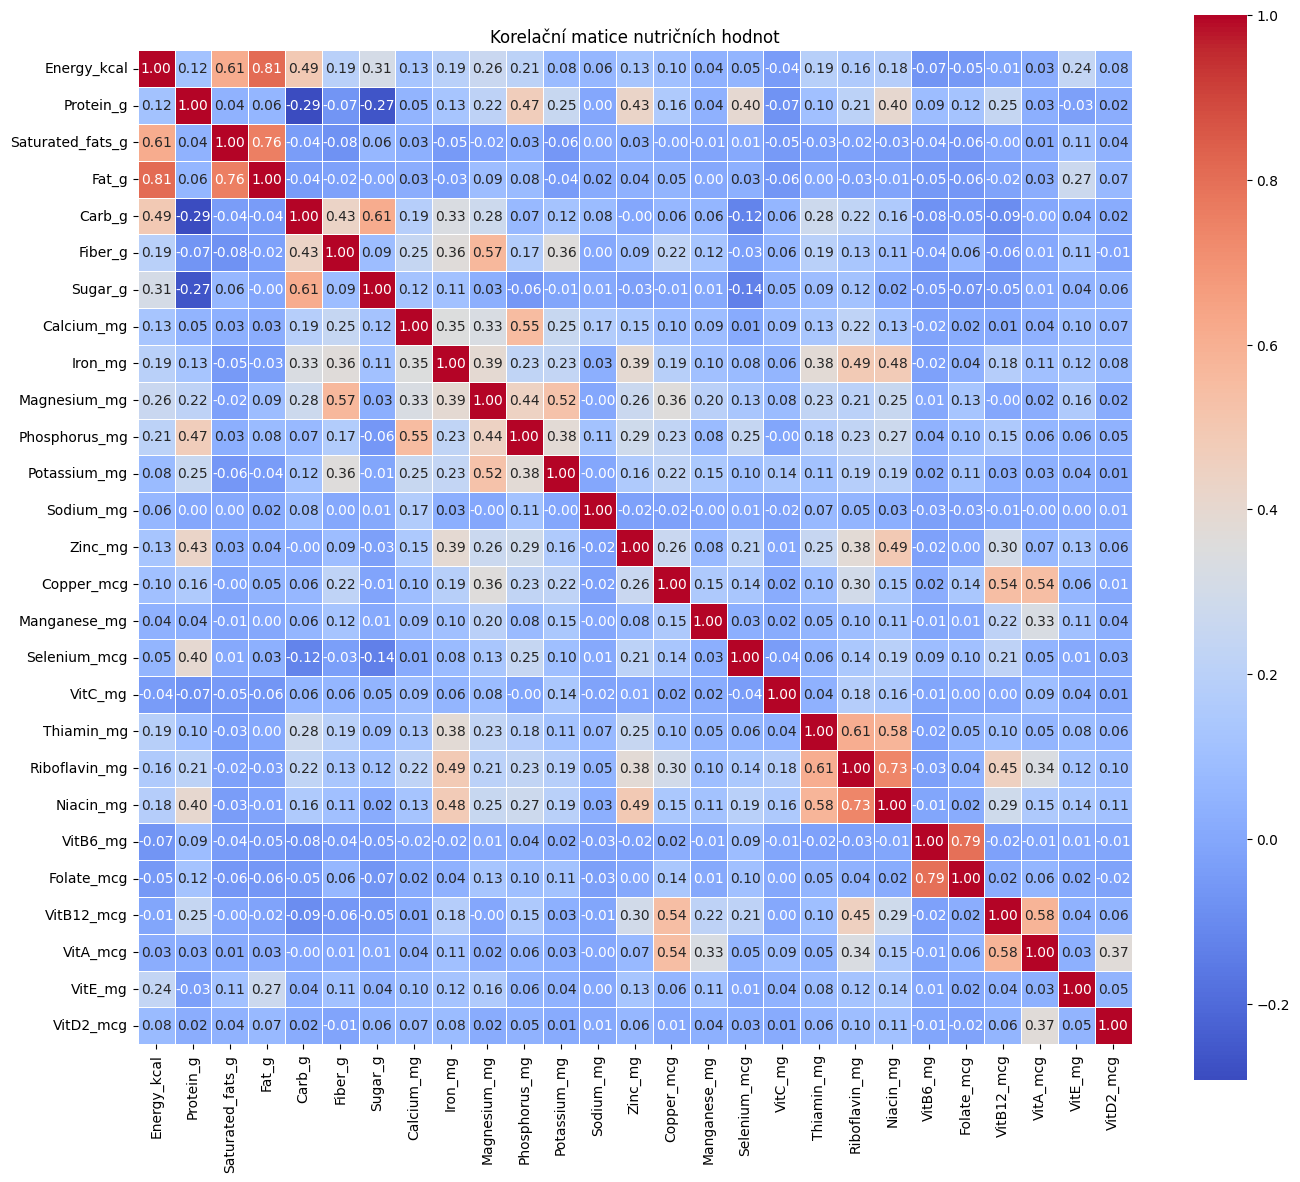

In [ ]:
import seaborn as sns


numeric_df = df_filtered.select_dtypes(include='number')


correlation_matrix = numeric_df.corr()


plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Korelační matice nutričních hodnot")
plt.tight_layout()
plt.show()

Korelačná matica odhaľuje viacero očakávaných aj zaujímavých vzťahov medzi výživovými zložkami.

**Silná pozitívna korelácia medzi:**

*   Fat_g a Saturated_fats_g (r = 0.76) – očakávané, keďže nasýtené tuky sú podmnožinou tukov.

*   Protein_g a Energy_kcal (r = 0.61) – bielkoviny prispievajú k energetickej hodnote.

*   Fat_g a Energy_kcal (r = 0.61) – tuk je energeticky najbohatšia zložka.

*   Niacin_mg, Thiamin_mg, Riboflavin_mg, VitB6_mg – vitamíny B komplexu spolu silne korelujú (r > 0.6), čo je typické pre obohatené potraviny alebo prirodzený výskyt v rovnakých surovinách.

**Zaujímavé stredne silné korelácie:**

*   Phosphorus_mg a Magnesium_mg, Potassium_mg, Calcium_mg – naznačuje súvis medzi minerálmi typickými pre rastlinné aj živočíšne zdroje.

*   VitA_mcg a VitD2_mcg (r = 0.37) – mierna súvislosť, často prítomné spolu v obohatených potravinách.

**Žiadna alebo záporná korelácia:**

*   Sodium_mg má veľmi slabú alebo zápornú koreláciu s väčšinou živín – môže naznačovať, že sodík sa vyskytuje vo vysoko spracovaných potravinách, ktoré inak nemusia byť nutrične bohaté.

*   Sugar_g má nízke korelácie s ostatnými živinami, čo zodpovedá rôznorodému výskytu cukrov v potravinách.

# Distribúcia makroživín

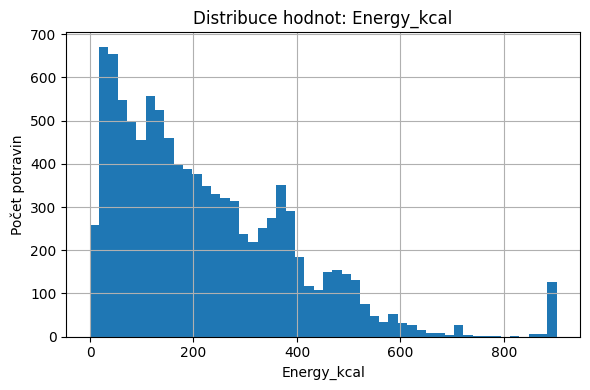

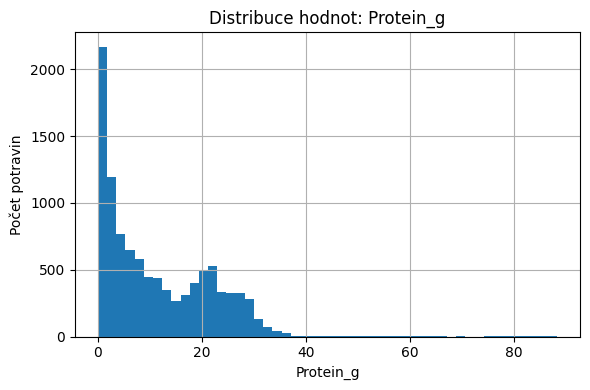

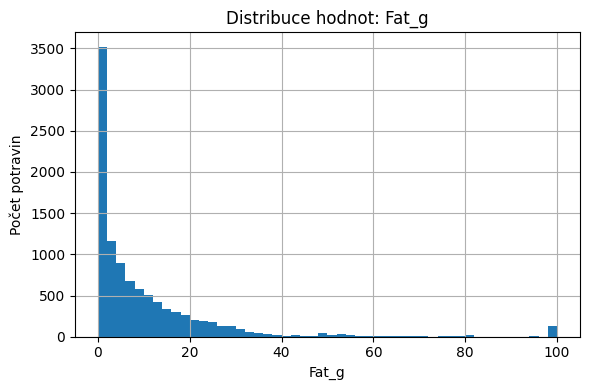

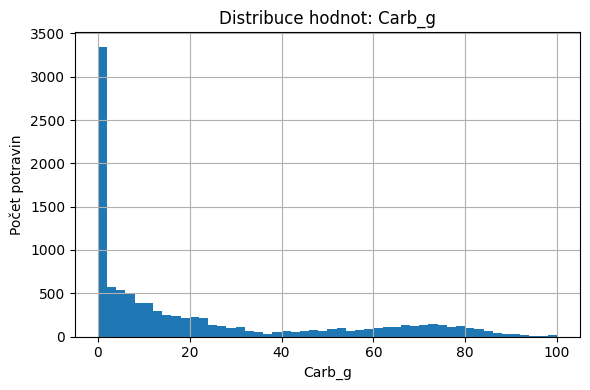

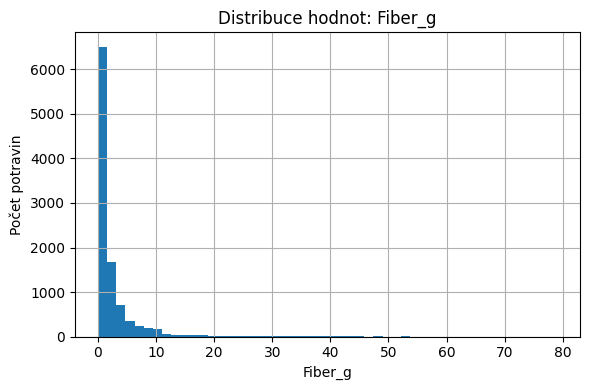

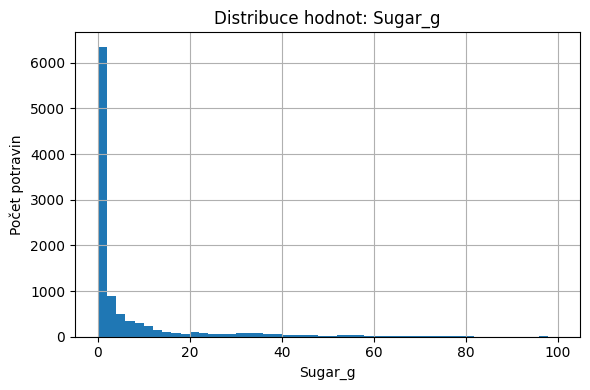

In [ ]:
import matplotlib.pyplot as plt

columns_to_plot = ['Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g', 'Fiber_g', 'Sugar_g']

for col in columns_to_plot:
    plt.figure(figsize=(6, 4))
    df_filtered[col].hist(bins=50)
    plt.title(f'Distribuce hodnot: {col}')
    plt.xlabel(col)
    plt.ylabel('Počet potravin')
    plt.ticklabel_format(style='plain', axis='x')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Analýza distribúcie makroživín po vyčistení dát

#### Energy_kcal
- Väčšina potravín má nízku až strednú energetickú hodnotu (0–400 kcal).
- Výrazne pravostranná distribúcia (tzv. „right-skewed“) s niekoľkými potravinami nad 800 kcal.
- Možný výskyt vysokoenergetických jedál (oleje, spracované produkty).

#### Protein_g
- Veľká väčšina potravín obsahuje do 20 g bielkovín, vrchol medzi 0–5 g.
- Mierne bimodálna distribúcia – jeden vrchol pri nízkych hodnotách, druhý okolo 20 g.
- Vysoké hodnoty (>50 g) sú zriedkavé a môžu byť doplnky alebo koncentráty.

#### Fat_g
- Silne pravostranná distribúcia.
- Veľa potravín s veľmi nízkym obsahom tuku (0–5 g), ale dlhý chvost až do 100 g (pravdepodobne oleje, maslá).

#### Carb_g
- Veľmi veľa potravín s takmer nulovým obsahom sacharidov.
- Druhý pík medzi 60–80 g – pravdepodobne cereálie, sladkosti, pečivo.
- Možná prítomnosť normalizovaných hodnôt na 100 g porcie.

#### Fiber_g
- Väčšina potravín má veľmi nízky obsah vlákniny (0–5 g).
- Dlhý chvost až po 79 g – tieto extrémne hodnoty sú zriedkavé a možno chybné (pozrieť outliery).

#### Sugar_g
- Extrémne veľa potravín s nulovým obsahom cukru.
- Chvost distribúcie smerom k 100 g – pravdepodobne obsahuje čisté sladidlá, cukry, sirupy.
- Prehľadná distribúcia s jasnými extrémami.


# Preproccessing


Odstránenie záporných hodnôt v 'Energy_kcal'

In [ ]:
df_filtered = df_filtered[df_filtered['Energy_kcal'] >= 0]

Odstránenie duplikátov

In [ ]:
# 1. Zistenie a zobrazenie duplicitných riadkov
duplicates = df_filtered.duplicated(keep=False)  # Označí všetky výskyty duplicitných riadkov
num_duplicates = duplicates.sum()  # Počet duplicitných riadkov
duplicate_rows = df_filtered[duplicates].sort_values(by="Descrip").head(10)  # Ukážka prvých 10

print(f"Počet duplicitných riadkov v dátach: {num_duplicates}")
print("Ukážka duplicitných záznamov:")
print(duplicate_rows)

# 2. Odstránenie duplikátov
df_filtered_nodup = df_filtered.drop_duplicates()  # Zachová len prvý výskyt

# 3. Porovnanie pred a po odstránení
original_count = df_filtered.shape[0]
cleaned_count = df_filtered_nodup.shape[0]
num_removed = original_count - cleaned_count

print("\nPrehľad po odstránení duplikátov:")
print(f"- Pôvodný počet riadkov: {original_count}")
print(f"- Počet riadkov po odstránení duplikátov: {cleaned_count}")
print(f"- Počet odstránených riadkov: {num_removed}")


Počet duplicitných riadkov v dátach: 1848
Ukážka duplicitných záznamov:
      NDB_No                                 Descrip  Energy_kcal  Protein_g  \
9504    9002                       acerola juice raw         23.0       0.40   
148     9002                       acerola juice raw         23.0       0.40   
4026   14248    alcoholic bev beer lt higher alcohol         46.0       0.25   
8672   14248    alcoholic bev beer lt higher alcohol         46.0       0.25   
10077  14009              alcoholic bev daiquiri cnd        125.0       0.00   
3838   14009              alcoholic bev daiquiri cnd        125.0       0.00   
5375   14051  alcoholic bev distilled vodka 80 proof        231.0       0.00   
5254   14051  alcoholic bev distilled vodka 80 proof        231.0       0.00   
4518   14027          alcoholic bev whiskey sour cnd        119.0       0.00   
5389   14027          alcoholic bev whiskey sour cnd        119.0       0.00   

       Saturated_fats_g  Fat_g  Carb_g  Fiber_g

# Finálne predspracované dáta

In [ ]:
null_counts = df_filtered_nodup.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

VitE_mg             6
VitC_mg             5
VitA_mcg            5
Selenium_mcg        4
Riboflavin_mg       4
Fiber_g             4
Magnesium_mg        3
Carb_g              3
Fat_g               3
Calcium_mg          3
Manganese_mg        3
Saturated_fats_g    2
Phosphorus_mg       2
VitD2_mcg           2
Sodium_mg           2
Copper_mcg          2
Potassium_mg        2
Zinc_mg             2
VitB12_mcg          2
Iron_mg             1
Protein_g           1
Thiamin_mg          1
Folate_mcg          1
Niacin_mg           1
VitB6_mg            1
dtype: int64

In [ ]:
df_final = df_filtered_nodup.copy()
# Odstranění řádků obsahující nějakou NaN hodnotu.
# Neděláme imputaci a odstranujeme, protože je v datech celkoví počet NaN hodnot pouze v řádech malých desítek, zatímco máme tísíce dat.
df_final.dropna(inplace=True)
df_final.shape

(9203, 29)

# Použité modely

Našou úlohou je CLUSTERING a podľa typu úlohy a exploračnej analýzy zvolili modely **K-means** a **DBSCAN**. Pri oboch modeloch využívame aj ohodnocovanie podľa viacerých metrík.


## K-means

K-means. Algoritmus začíná náhodným výběrem počátečních centroidů (středových bodů). Poté probíhá iterativní proces, během něhož jsou body přiřazovány k nejbližšímu centroidu (typicky eukleidovská vzdálenost)a následně se centroidy aktualizují jako průměr všech bodů v příslušném shluku. Tento cyklus se opakuje, dokud se přiřazení bodů nezmění nebo dokud není dosaženo maximálního počtu iterací.

Výsledkem učení modelu je rozdělení datasetu na k shluků, kde každý shluk je reprezentován svým centroidem a souborem přiřazených datových bodů. Nevýhodou je, že počet shluků je nutné určit předem a výsledek může záviset na počátečním náhodném výběru centroidů. Proto se obvykle provádí více běhů s různými inicializacemi a vybírá se nejlepší výsledek podle některé z hodnoticích metrik.


## DBSCAN
### (Density-Based Spatial Clustering of Applications with Noise)

Patrí medzi algoritmy, ktoré vytvárajú zhluky podľa hustoty bodov v priestore. Na rozdiel od K-means nie je potrebné dopredu určovať počet zhlukov, čo je jeho veľká výhoda. Ďalším plusom je, že je odolný voči odľahlým bodom (outlierom) a dobre pracuje aj so zhlukmi nepravidelných tvarov.

### Parametre:
- **`eps`** (epsilon): maximálna vzdialenosť, v ktorej sa hľadajú susedné body okolo daného bodu.
- **`min_samples`**: minimálny počet susedov v danom okolí, aby sa bod považoval za jadro (core point) zhluku.

### Princíp fungovania:
- Ak má bod vo svojom okolí (vzdialenosť `eps`) aspoň `min_samples` bodov, je označený ako **jadrový bod**.
- Z jadrového bodu sa začne tvoriť zhluk – k nemu sa pripoja všetky body v jeho okolí, ktoré takisto spĺňajú podmienky hustoty.
- Tento proces sa rekurzívne opakuje pre každý novo pridaný bod, čím sa zhluk ďalej rozširuje.
- **Body, ktoré sa nenachádzajú v žiadnom zhluku, sú označené ako šum** – ide o bodové hodnoty, ktoré nezapadajú do žiadnej skupiny.


# K-means

Silhouette vizualizace pro k=2


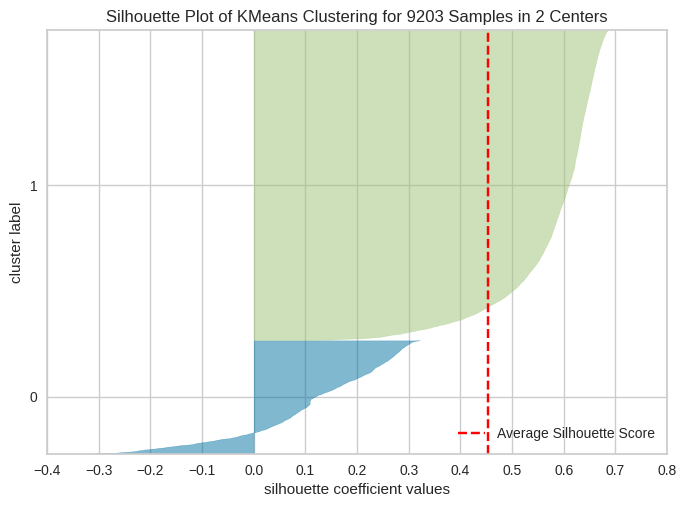

Silhouette vizualizace pro k=3


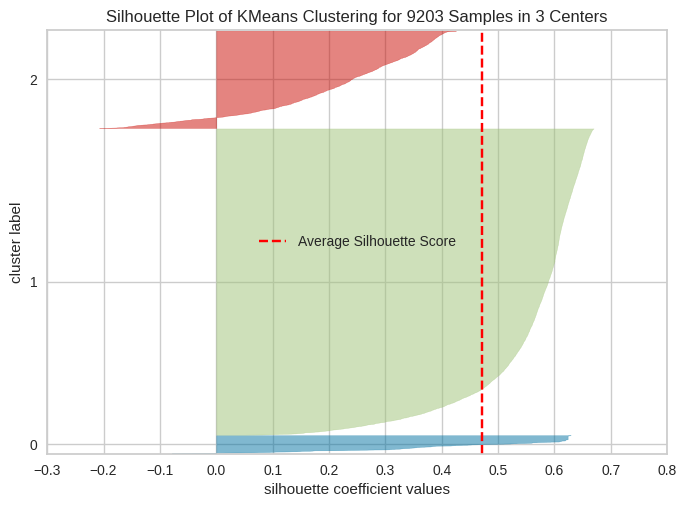

Silhouette vizualizace pro k=4


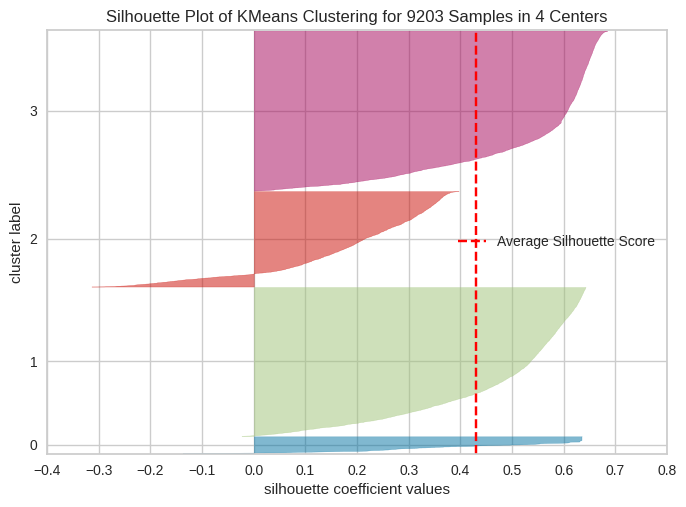

Silhouette vizualizace pro k=5


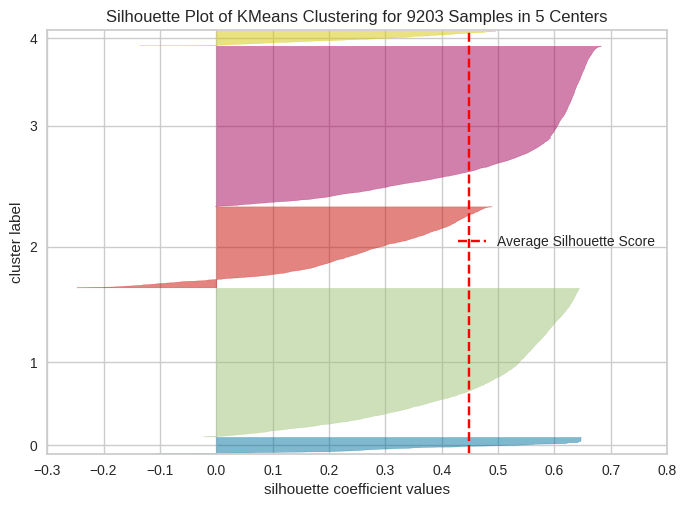

Silhouette vizualizace pro k=6


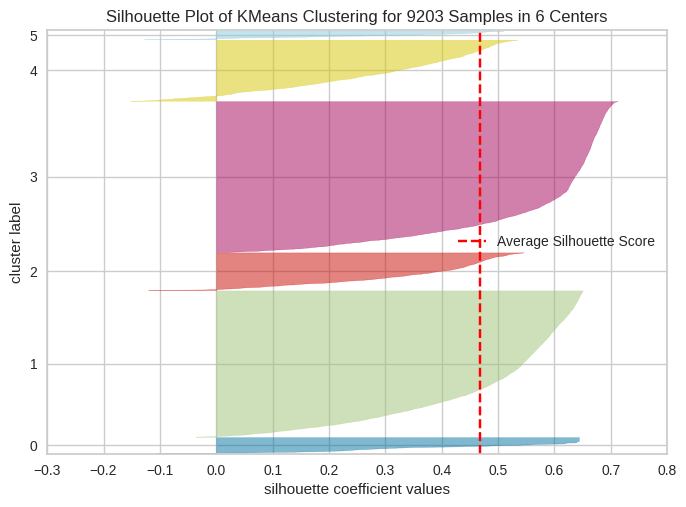

Silhouette vizualizace pro k=7


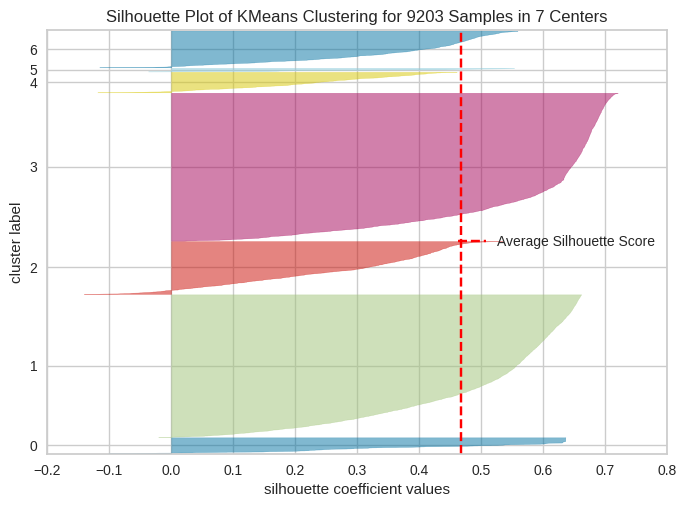

Silhouette vizualizace pro k=8


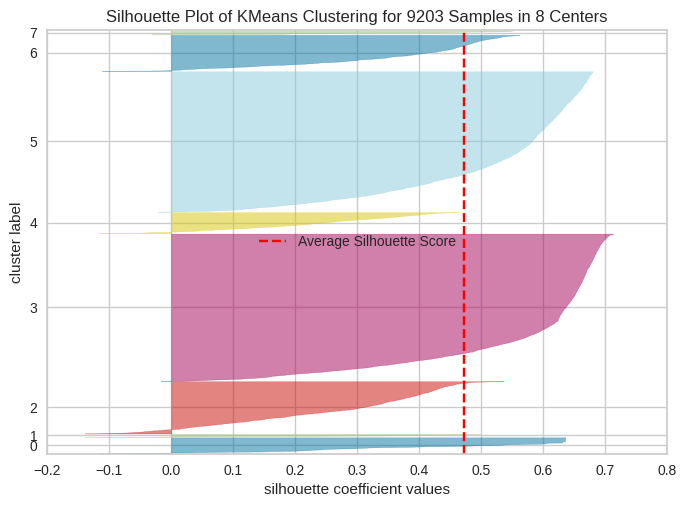

In [ ]:
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# výběr features, makroživiny. Jenom obecný tuk a ne saturovaný kvůli korelaci a věcné potravinářské blízkosti.
features = ['Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g', 'Fiber_g', 'Sugar_g']
X = df_final[features].dropna()

# standardizace
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# používání random_state=42, kvůli konzistenci výsledků pro jejich prezentaci a replikaci.
for k in range(2, 9):
    print(f"Silhouette vizualizace pro k={k}")
    model = KMeans(n_clusters=k, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(X_scaled)
    visualizer.show()

Silhouette vizualizace pro k=2


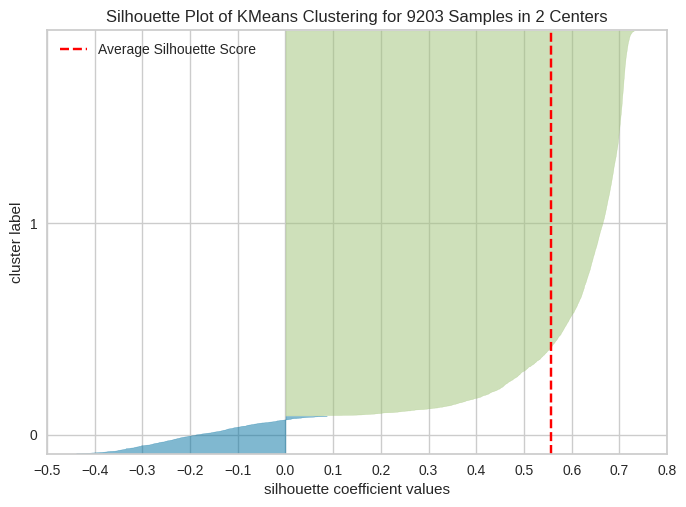

Silhouette vizualizace pro k=3


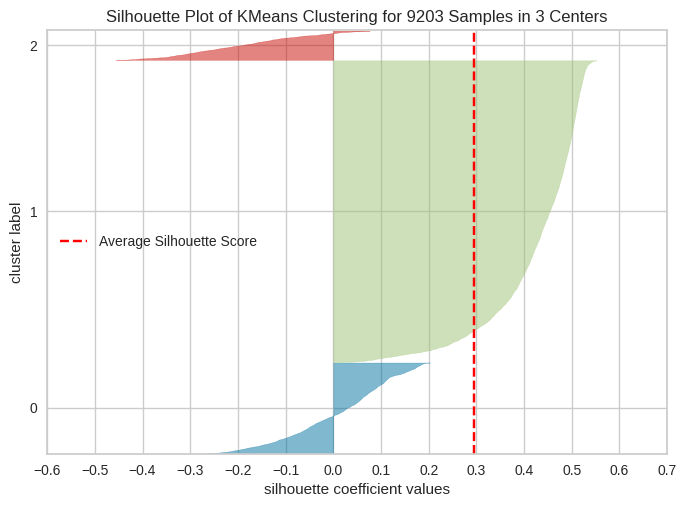

Silhouette vizualizace pro k=4


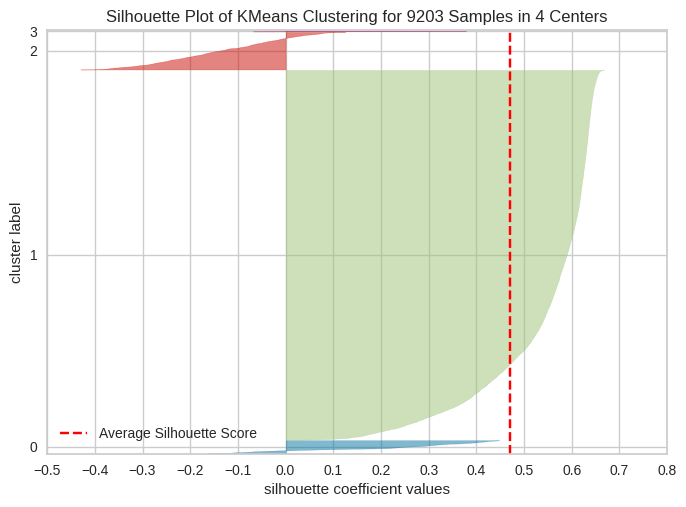

Silhouette vizualizace pro k=5


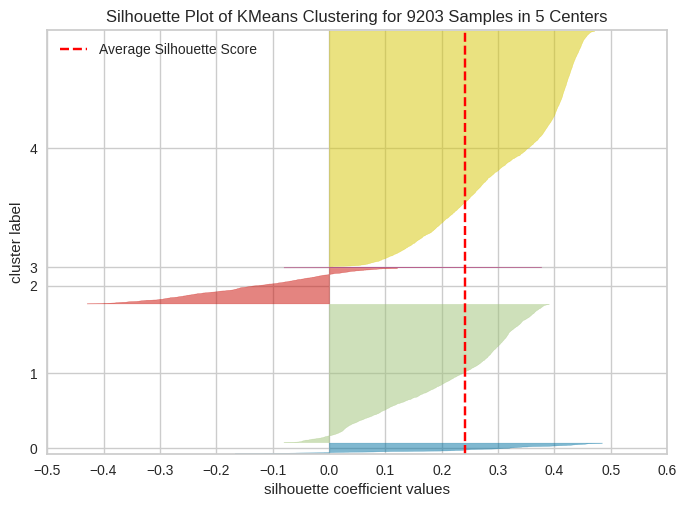

Silhouette vizualizace pro k=6


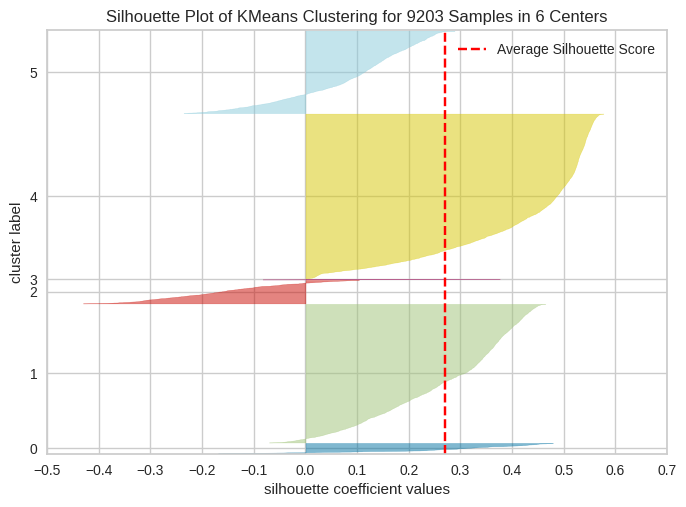

Silhouette vizualizace pro k=7


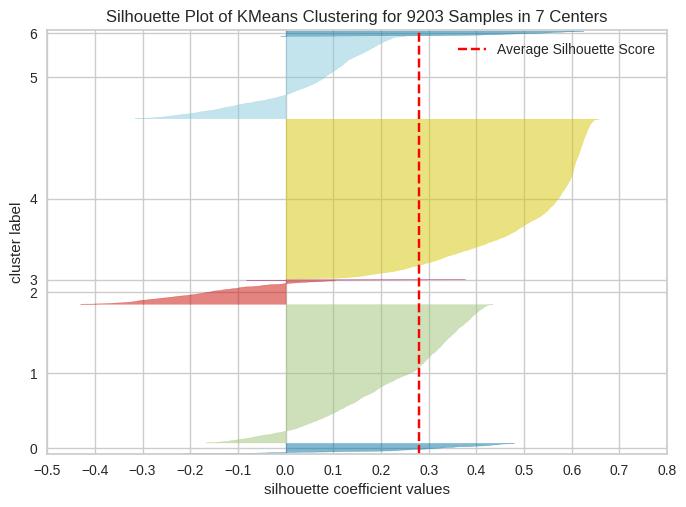

Silhouette vizualizace pro k=8


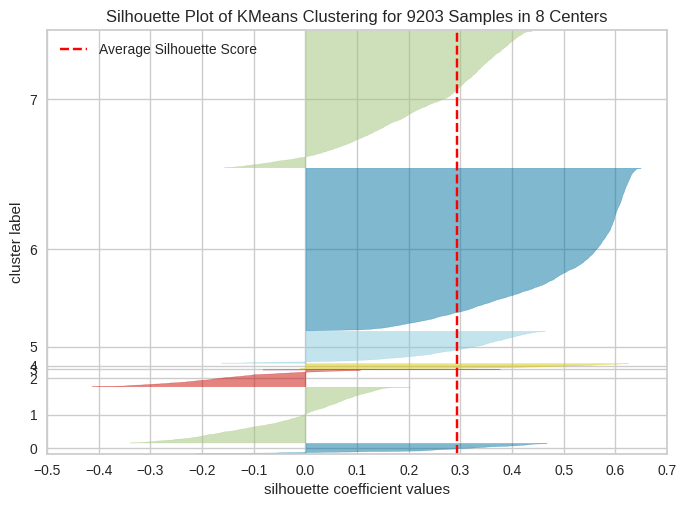

In [ ]:

# výběr features, všechny, pro porovnání jestli budou hodnoty vypadat víc slibně
X = df_final.drop(columns="NDB_No").drop(columns="Descrip")

# standardizace
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for k in range(2, 9):
    print(f"Silhouette vizualizace pro k={k}")
    model = KMeans(n_clusters=k, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(X_scaled)
    visualizer.show()

Hodnoty jen s makroživiny vypadají více slibně. S růstajícím počtem clusterů silhouette skore rychleji klesá u verze se všemi features než u verze s makroživiny. Počty u velmi málého K (např. 2) nás moc nezajímají, protože rozdělovat potraviny do dvou shluků není moc zajímavé ani užitečné. Spíš nás zajímají hodnoty 5+, a tam má verze s makroživiny znatelně lepší výsledky.

Ted hledáme vhodné K, pomocí více metrik pro data s makroživinami.

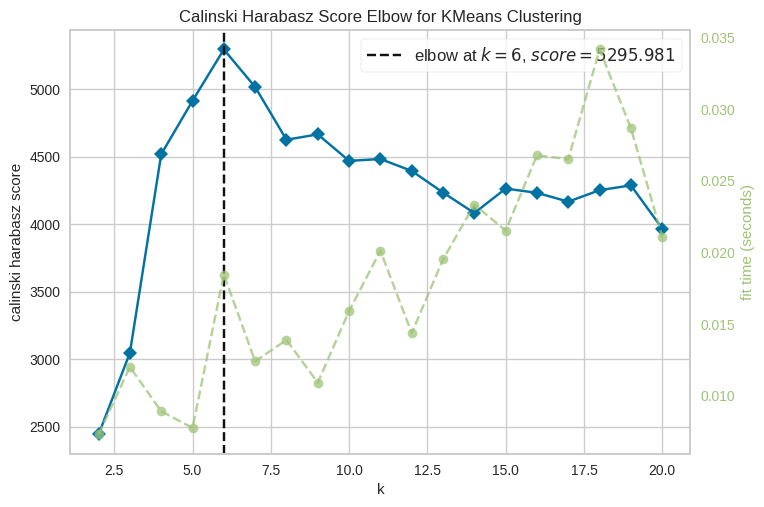

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

features = ['Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g', 'Fiber_g', 'Sugar_g']
X_train = df_final[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

vizualizer = KElbowVisualizer(KMeans(), metric="calinski_harabasz", k=20, random_state=42)
vizualizer.fit(X_scaled)
vizualizer.show()

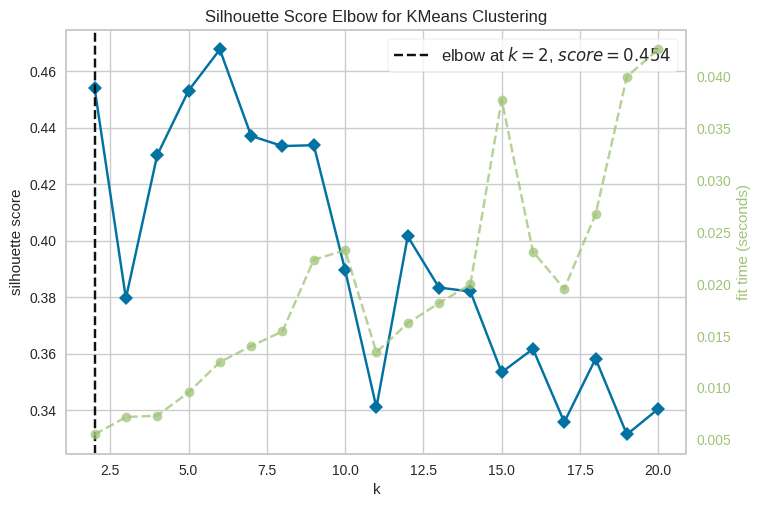

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

features = ['Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g', 'Fiber_g', 'Sugar_g']
X_train = df_final[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

vizualizer = KElbowVisualizer(KMeans(), metric="silhouette", k=20, random_state=42)
vizualizer.fit(X_scaled)
vizualizer.show()

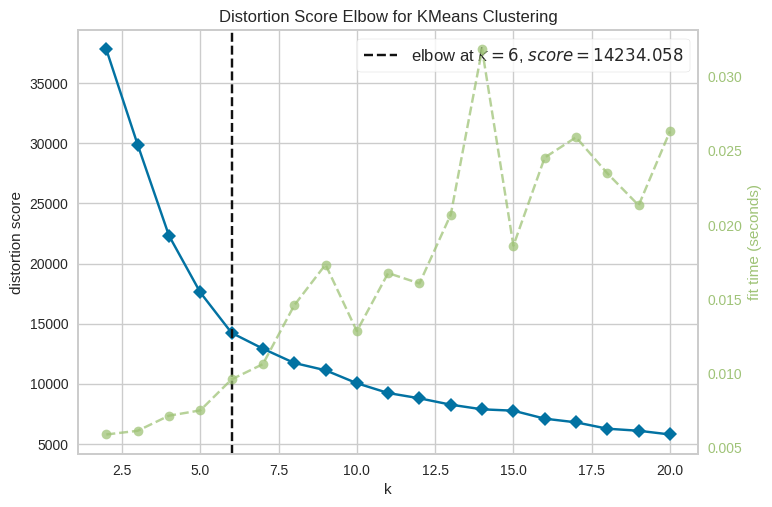

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

features = ['Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g', 'Fiber_g', 'Sugar_g']
X_train = df_final[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

vizualizer = KElbowVisualizer(KMeans(), metric="distortion", k=20, random_state=42)
vizualizer.fit(X_scaled)
vizualizer.show()

Z disortion metriky nám výšlo jako ideální K = 6. I v silhouette a calinski metrikách byla hodnota pro K = 6 relativně vysoká, což je dobré znamení.
Proto teda vybíráme hodnotu 6 pro K. (Výsledky nemusí vycházet vždy stejně a elbow nemusí být vždy určen na K = 6, ale hodnoty by měli být pro 6 většinou dost dobré)

In [ ]:
def plot_clusters(data, clusters): # pomocná funkce pro vizualizaci clusteringu ze cvičení. Zdroj: cvičení 7.
    """
    Plots clusters using scatter plot and color them acordingly.

    :param pd.DataFrame data: dataframe with datapoints havig columns "x" and "y"
    :param list of int clusters: cluster label for each of the datapoint
    """
    # find outliers not belonging to any cluster (only relevant for DBSCAN)
    outlier_indices = clusters == -1

    # plot points and color them by cluster/label
    ax = sns.scatterplot(
        data=data[~outlier_indices],
        x="x",
        y="y",
        hue=clusters[~outlier_indices],
        palette="muted",
        legend=False,
    )

    if outlier_indices.any():
        ax = sns.scatterplot(
            data=data[outlier_indices], x="x", y="y", color="black", ax=ax
        )
    return ax

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

pipeline = make_pipeline(
    StandardScaler(),
)

kmeans = KMeans(n_clusters=6, random_state=42)

features = ['Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g', 'Fiber_g', 'Sugar_g']
X_train = df_final[features]

X_clusters = pipeline.fit_transform(X_train)
X_clusters = kmeans.fit_predict(X_clusters)

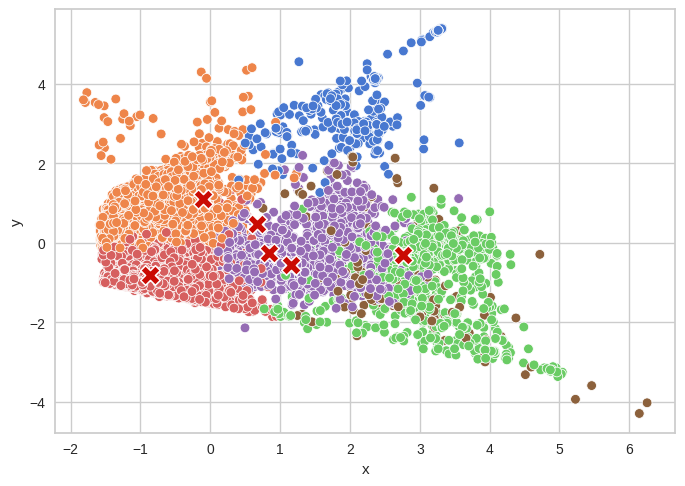

In [ ]:
# PCA redukce na 2D pro vizualizaci
from sklearn.decomposition import PCA

pca_pipeline = make_pipeline(
    pipeline,  # pouze StandardScaler
    PCA(n_components=2),
)

X_pca = pca_pipeline.fit_transform(X_train)

import pandas as pd

X_pca = pd.DataFrame(X_pca, columns=["x", "y"])
plot_clusters(X_pca, X_clusters)

sns.scatterplot(
    x=kmeans.cluster_centers_[:, 0],
    y=kmeans.cluster_centers_[:, 1],
    marker="X",
    color="r",
    s=200,
)
plt.show()

In [ ]:
from IPython.display import display

features = ['Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g', 'Fiber_g', 'Sugar_g']
X_train = df_final[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_clusters = df_final.copy()
df_clusters['Cluster'] = clusters

cluster_summary = df_clusters.groupby('Cluster')[features].mean().round(2)
cluster_sizes = df_clusters['Cluster'].value_counts().sort_index()

display(cluster_summary)

profile = df_clusters[features + ['Cluster']]
mean_profile = profile.groupby('Cluster').mean().round(2)
std_profile  = profile.groupby('Cluster').std().round(2)

print("\nStandardní odchylka ve shlucích:")
print(std_profile)

print("Počet položek ve shlucích:")
print(cluster_sizes)

Energy_kcal  Protein_g  Fat_g  Carb_g  Fiber_g  Sugar_g
Cluster                                                         
0             688.52       8.17  71.55    7.45     2.59     1.53
1             203.36      22.70  11.13    2.37     0.19     0.40
2             417.18       5.60  13.72   69.55     2.78    43.68
3              75.34       2.78   1.90   11.87     1.63     4.04
4             362.81       8.74  10.24   60.73     4.49     5.78
5             333.41      16.37   9.00   56.16    24.79     6.62


Standardní odchylka ve shlucích:
         Energy_kcal  Protein_g  Fat_g  Carb_g  Fiber_g  Sugar_g
Cluster                                                         
0             151.62       9.31  21.75   10.16     4.15     3.01
1              79.29       7.54   8.28    6.02     0.79     1.53
2              84.96       4.95  10.71   13.18     2.82    15.49
3              54.38       2.85   3.43    8.49     1.89     5.35
4              80.99       4.48   9.34   17.06     3.68     7.30
5              80.77       9.38  10.96   18.91    10.95    10.13
Počet položek ve shlucích:
Cluster
0     353
1    3203
2     823
3    3301
4    1336
5     187
Name: count, dtype: int64


Model K-Means rozčlenil potraviny do šesti skupin na základě jejich nutričního složení. Během trénování se model naučil rozlišovat potraviny podle kombinací makroživin – kalorií, bílkovin, tuků, sacharidů, vlákniny a cukrů. Každý shluk je reprezentován centroidem, který udává průměrné složení typické potraviny daného typu. Tím model rozdělil potraviny do skupin podle podobnosti v těchto hodnotách.

Výše je tabulka průměrných hodnot makroživin pro každý cluster, standardní odchylka a počet objektů ve shlucích.


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np

# Vyhodnocení modelu
silhouette = silhouette_score(X_scaled, clusters)
calinski = calinski_harabasz_score(X_scaled, clusters)
davies = davies_bouldin_score(X_scaled, clusters)

# Baseline:
random_labels = np.random.randint(0, 6, size=len(X_scaled))
silhouette_rand = silhouette_score(X_scaled, random_labels)
calinski_rand = calinski_harabasz_score(X_scaled, random_labels)
davies_rand = davies_bouldin_score(X_scaled, random_labels)


evaluation_results = pd.DataFrame({
    'Metrika': ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'],
    'Model': [silhouette, calinski, davies],
    'Baseline (náhoda)': [silhouette_rand, calinski_rand, davies_rand]
}).round(3)

evaluation_results

Metrika     Model  Baseline (náhoda)
0         Silhouette     0.468             -0.015
1  Calinski-Harabasz  5296.173              0.748
2     Davies-Bouldin     0.859             79.020

Hodnocení clusteringu podle baseline modelu není ideální, ale i přesto jsme provedli testy porovnávání našeho K-means s baseline modelem, který je založen na náhodném přiřazování.

Silhouette score měří, jak dobře jsou body přiřazeny ke svému shluku ve srovnání s jinými shluky. Hodnoty blízké 1 znamenají, že body jsou dobře oddělené, zatímco hodnoty blízké 0 nebo záporné znamenají překrývání shluků. Calinski-Harabasz index hodnotí poměr mezi meziskupinovou a vnitroskupinovou variabilitou, čím vyšší hodnota, tím lepší oddělení. Davies-Bouldin index hodnotí podobnost mezi shluky, nižší hodnota značí lepší oddělení.

Náš model funguje znatelně lépe než baseline model.

In [ ]:
df_with_clusters = df_final.copy()
df_with_clusters['Cluster'] = clusters

sampled_clusters = {}
for cluster_id in sorted(df_with_clusters['Cluster'].unique()):
    examples = (
        df_with_clusters[df_with_clusters['Cluster'] == cluster_id]
        .sample(n=10, random_state=42)['Descrip']
        .tolist()
    )
    sampled_clusters[f"Cluster {cluster_id}"] = examples

sampled_clusters

{'Cluster 0': ['veg oil sprd 60 fat sticktubbottle wo salt wvit d',
  'veal comp of rtl cuts fat ckd',
  'oil industrial palm  palm kernel filling fat (non-hydrog)',
  'oil industrial mid-oleic sunflower',
  'veal comp of rtl cuts fat raw',
  'pumpkinsquash sd krnls rstd wosalt',
  'oil olive salad or cooking',
  'peanut butter w omega-3 creamy',
  'peanut butter chunky vitaminmineral fort',
  'oil palm'],
 'Cluster 1': ['beef nz imp eye rnd ln raw',
  'game meat beaver raw',
  'pork cured ham w nat juics slce bne-in ln  fat htd pan-brl',
  'lamb dom leg whl (shksirl) lnfat 18"fat choic raw',
  'cheese cheddar nonfat or fat free',
  'beef rnd top rnd steak ln 18" fat choic raw',
  'beef shldr top blde stk bns ln  fat 0" fat choic ckd g',
  'beverages nutritional shake mix hi prot pdr',
  'chicken broilers or fryers back meat  skn ckd rotisserie or',
  'beef shrt loin top ln stk ln  fat 18" fat choic ckd grlld'],
 'Cluster 2': ["cereals rte kellogg kellogg's lofat granola w raisins",
  

Kromě numerických metrik jsme model vyhodnotili také na základě interpretační smysluplnosti vytvořených shluků. Pro každý shluk jsme analyzovali jejich složení i typ. Výše je ukázaná malá výseč potravin obsažených v individuálních shlucích. Výsledky ukazují, že model K-Means vytvořil skupiny, které relativně dobře odpovídají běžně chápaným kategoriím potravin.

Například:

Cluster 0: oleje, sádlo, masové produkty s velkým obsahem tuku, tučné ořechy → označili jsme ho jako „tukový, olejový cluster“

Cluster 1: různé druhy masa, mléčné produkty a potraviny s vysokým obsahem proteinu → „masový, proteinový cluster“

Cluster 2: sladkosti, sušenky, sladké pochutiny → „sladký cluster“

Cluster 3: byl nejvíce různorodý, zelenina a tekutiny → typicky „nízkokalorický / tekutý cluster“

Cluster 4: pečivo, cereálie, rýže → „obilný cluster“

Cluster 5: luštěniny, semena, zelenina a cereálie s vysokým obsahem vlákniny → „rostlinný a vlákninový cluster“

Tato klasifikace dává jasný výživový i praktický smysl a ukazuje, že model se naučil rozpoznávat přirozené rozdíly ve výživových profilech potravin.


# DBSCAN

Výpočet a nájdenie parametrov tu nie je kódovo obsiahnuté celé. Pri viacerých loopoch totižto dochádyalo k dlhším časovým úsekom výpočtu, a pre prehľadnosť a čistotu notebooku som niektore časti považoval za zbytočné.

**Výber parametrov** -
Rozhodol som sa pracovať individuálne s markoživinami a vitamínmi, a na konci výsledky porovnať. Pracovanie s menšími množinami parametrov neviedli k lepším výsledkom a už vôbec nie, ak som dáta clustroval ako celok.

## Makroživiny

Vykreslenie krivky pre eps, ako pomôcka, pri akých hodnotách sa budeme pohybovať

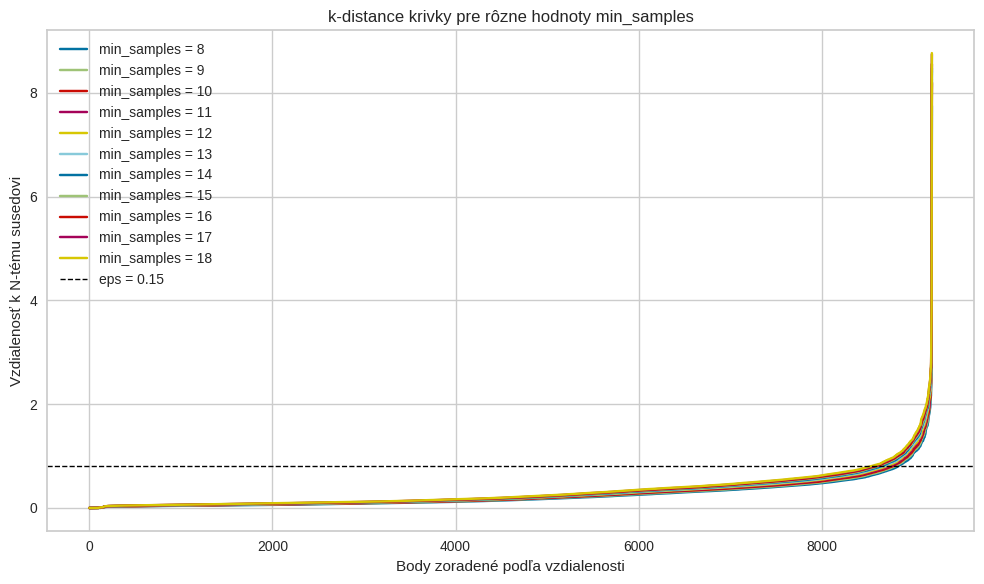

In [ ]:
# Výber príznakov
features = ['Energy_kcal','Protein_g','Fat_g','Carb_g','Fiber_g','Sugar_g']
X_sel = df_final[features].values

# Štandardizácia
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sel)

plt.figure(figsize=(10,6))

for min_samples in range(8, 19):
    nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
    dist, _ = nbrs.kneighbors(X_scaled)
    k_dist = np.sort(dist[:, -1])  # vzdialenosť k N-tému najbližšiemu susedovi
    plt.plot(k_dist, label=f'min_samples = {min_samples}')

plt.axhline(0.8, color='black', linestyle='--', linewidth=1, label='eps = 0.15')

plt.title('k-distance krivky pre rôzne hodnoty min_samples')
plt.xlabel('Body zoradené podľa vzdialenosti')
plt.ylabel('Vzdialenosť k N-tému susedovi')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Po detailnejšom zanalyzovaní som sa zameral na menši interval, v kotorm som skúmal tu najlepšiu dvojicu eps a min_samples

In [ ]:
# Príprava dát a škálovanie
features      = ['Energy_kcal','Protein_g','Fat_g','Carb_g','Fiber_g','Sugar_g']
X_sel         = df_final[features].values
X_scaled      = StandardScaler().fit_transform(X_sel)

# Určenie intervalu
eps_values    = np.arange(0.10, 0.30, 0.05)
min_samp_vals = range(8, 18)
n             = len(X_scaled)


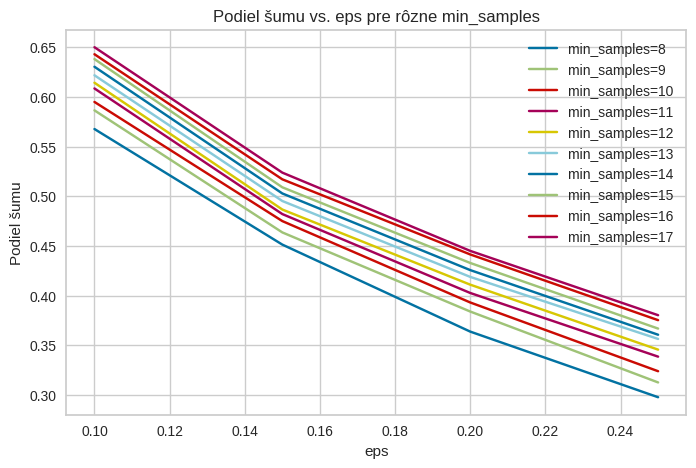

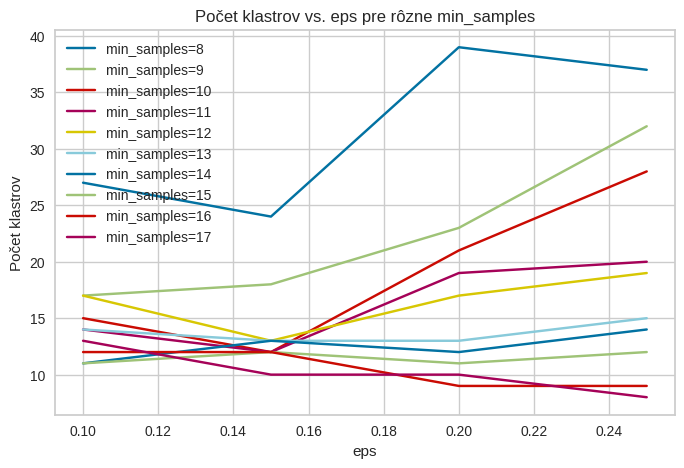

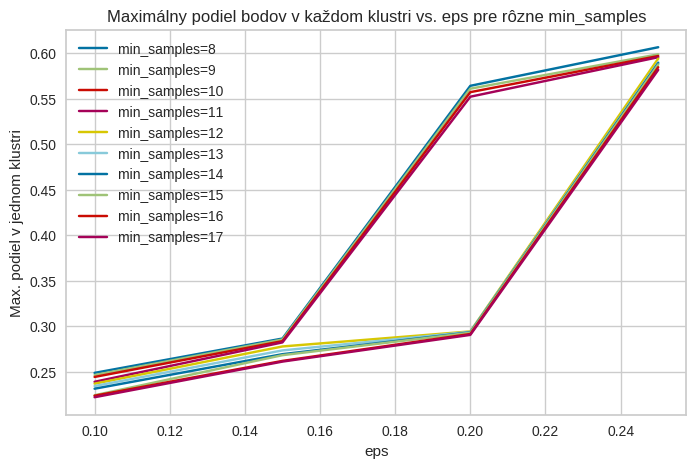

In [ ]:
results = []
for eps in eps_values:
    for ms in min_samp_vals:
        labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(X_scaled)
        n_clusters       = len(set(labels)) - (1 if -1 in labels else 0)
        noise_frac       = np.mean(labels == -1)
        sizes            = np.bincount(labels[labels >= 0])
        small_sizes      = sizes[sizes < (n * 0.1)]
        mean_small       = small_sizes.mean() if len(small_sizes) > 0 else np.nan
        max_cluster_frac = sizes.max() / n if len(sizes) > 0 else 0

        results.append({
            'eps': eps,
            'min_samples': ms,
            'n_clusters': n_clusters,
            'noise_frac': noise_frac,
            'mean_small_cluster': mean_small,
            'max_cluster_frac': max_cluster_frac
        })

df_res = pd.DataFrame(results)

import matplotlib.pyplot as plt

# Predpokladáme, že df_res, eps_values, min_samp_vals sú už definované

# 1) Noise fraction vs. eps pre rôzne min_samples
plt.figure(figsize=(8, 5))
for ms in min_samp_vals:
    subset = df_res[df_res['min_samples'] == ms]
    plt.plot(subset['eps'], subset['noise_frac'], label=f'min_samples={ms}')
plt.xlabel('eps')
plt.ylabel('Podiel šumu')
plt.title('Podiel šumu vs. eps pre rôzne min_samples')
plt.legend()
plt.grid(True)
plt.show()

# 2) Počet klastrov vs. eps pre rôzne min_samples
plt.figure(figsize=(8, 5))
for ms in min_samp_vals:
    subset = df_res[df_res['min_samples'] == ms]
    plt.plot(subset['eps'], subset['n_clusters'], label=f'min_samples={ms}')
plt.xlabel('eps')
plt.ylabel('Počet klastrov')
plt.title('Počet klastrov vs. eps pre rôzne min_samples')
plt.legend()
plt.grid(True)
plt.show()

# 3) Maximálny podiel bodov v jednom klustri vs. eps pre rôzne min_samples
plt.figure(figsize=(8, 5))
for ms in min_samp_vals:
    subset = df_res[df_res['min_samples'] == ms]
    plt.plot(subset['eps'], subset['max_cluster_frac'], label=f'min_samples={ms}')
plt.xlabel('eps')
plt.ylabel('Max. podiel v jednom klustri')
plt.title('Maximálny podiel bodov v každom klustri vs. eps pre rôzne min_samples')
plt.legend()
plt.grid(True)
plt.show()




Po dokladnej analyze som sa rozhodol urcit parametre **eps** = 0.2 a **min_samples** = 15

Metriky ako Silhouette Score nedávali tejto kombinacii velmi priaznivé skóre, ale pretože skore bolo pozitivne v pripadoch ked informačná hodnota výsledných klastrov bola velmi nizka, rozhodol som sa týmito metrikami až tak neriadiť, a zamerať sa na pridanú hodnotu výledných klastrov.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster      import DBSCAN
from sklearn.neighbors    import NearestNeighbors
from sklearn.metrics      import silhouette_score, davies_bouldin_score, calinski_harabasz_score

eps_value       = 0.2
min_samples_val = 15

features = ['Energy_kcal','Protein_g','Fat_g','Carb_g','Fiber_g','Sugar_g']
X        = df_final[features].values
X_scaled = StandardScaler().fit_transform(X)

# Tréning DBSCAN
db     = DBSCAN(eps=eps_value, min_samples=min_samples_val)
labels = db.fit_predict(X_scaled)
df_final['cluster'] = labels


### Počty klastrov a podiel šumu

In [ ]:
counts  = df_final['cluster'].value_counts().sort_index()
percent = (counts / counts.sum() * 100).round(2)
cluster_summary = pd.DataFrame({
    'cluster': counts.index,
    'count':   counts.values,
    'percent': percent.values
})
print("\nVeľkosti klastrov a podiel na dátach:")
print(cluster_summary.to_string(index=False))


Veľkosti klastrov a podiel na dátach:
 cluster  count  percent
      -1   3984    43.29
       0   2695    29.28
       1    111     1.21
       2   2227    24.20
       3     30     0.33
       4     20     0.22
       5     41     0.45
       6     19     0.21
       7     23     0.25
       8     19     0.21
       9     19     0.21
      10     15     0.16


### Kvalitatívne metriky (bez šumu)

In [ ]:
mask = labels != -1
if len(set(labels[mask])) > 1:
    sil = silhouette_score(X_scaled[mask], labels[mask])
    dbs = davies_bouldin_score(X_scaled[mask], labels[mask])
    ch  = calinski_harabasz_score(X_scaled[mask], labels[mask])
    print(f"\nSilhouette score (bez šumu):       {sil:.3f}")
    print(f"Davies–Bouldin score (bez šumu):   {dbs:.3f}")
    print(f"Calinski–Harabasz score (bez šumu): {ch:.3f}")
else:
    print("\nNedá sa vypočítať metriky – málo klastrov alebo iba šum.")



Silhouette score (bez šumu):       0.310
Davies–Bouldin score (bez šumu):   0.526
Calinski–Harabasz score (bez šumu): 3376.834


### Profilovanie klastrov (mean + std)

In [ ]:
profile = df_final[features + ['cluster']]
mean_prof = profile.groupby('cluster').mean().round(2)
std_prof  = profile.groupby('cluster').std().round(2)


print("\nPriemerné hodnoty príznakov v klastroch:")
print(mean_prof)

print("\nŠtandardné odchýlky príznakov v klastroch:")
print(std_prof)


Priemerné hodnoty príznakov v klastroch:
         Energy_kcal  Protein_g  Fat_g  Carb_g  Fiber_g  Sugar_g
cluster                                                         
-1            320.57       9.40  13.01   43.17     4.20    12.70
 0            184.72      22.87   9.81    0.32     0.00     0.06
 1            887.23       0.02  99.90    0.00     0.00     0.00
 2             47.57       1.63   0.77    8.77     1.21     3.47
 3            363.70      10.27   1.40   75.95     2.45     0.57
 4            128.65       3.01   6.84   13.88     0.00    13.15
 5            275.63      11.76  11.70   30.81     2.09     3.55
 6            514.89      11.14  27.37   56.05     0.00    55.81
 7            112.84       6.88   0.71   20.25     5.10     1.31
 8            717.47       0.55  80.29    0.97     0.00     0.03
 9            110.68       5.31   3.34   15.42     2.07     1.84
 10            82.27       5.01   0.91   13.97     4.36     1.51

Štandardné odchýlky príznakov v klastroch:
    

### Ukážka položiek v každom klastri

In [ ]:
print("\nUkážka potravín v jednotlivých klastroch:")
for cid, grp in df_final.groupby('cluster'):
    print(f"\nCluster {cid} (n={len(grp)}):")
    for item in grp['Descrip'].head(20):
        print(" -", item)


Ukážka potravín v jednotlivých klastroch:

Cluster -1 (n=3984):
 - campbell's red  white crm of asparagus soup cond
 - kellogg's eggo mini muffin tops choc chip
 - cereals rte kellogg's crunchy nut golden honey nut flakes
 - cookies choc crm covered biscuit stks
 - bread wheat sprouted
 - campbell's chunky soups grilled steak- steak chili w bns
 - pork frsh spareribs lnfat ckd brsd
 - dip tostitos salsa con queso med
 - mother's taffy sndwch cookies
 - candies nestle after eight mints
 - syrups sorghum
 - sunshine cheez-it scrabble jr crackers
 - snacks popcorn home-prepared oil-popped unsalted
 - soy sau made from soy (tamari)
 - lamb nz imp frz shdr whl (armbld) ln  fat 18" ckd brsd
 - strudel apple
 - ham sliced reg (approx 11 fat)
 - jowar
 - usda commodity bf patties wvpp frz ckd
 - yogurt greek pln lowfat

Cluster 0 (n=2695):
 - pork cured ham  h2o product rump bone-in ln htd rstd
 - lamb nz imp hind-shank ln  fat ckd brsd
 - lamb dom leg whl (shksirl) lnfat 14"fat choic ckd rst

### 3D vykreslenie klastrov

In [ ]:
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

cluster_labels = df_final['cluster'].values

fig = make_subplots(
    rows=1, cols=1,
    subplot_titles=('DBSCAN Clustering (PCA 3D projekcia)'),
    specs=[[{'type': 'scatter3d'}]]
)

fig.add_trace(
    go.Scatter3d(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        z=X_pca[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=cluster_labels,
            colorscale='Viridis',
            opacity=0.7,
            showscale=True,
            colorbar=dict(title="Cluster")
        ),
        text=df_final['Descrip'],
        name='Potraviny'
    ),
    row=1, col=1
)

fig.update_layout(
    height=600,
    width=800,
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title_text="3D Vizualizácia DBSCAN klastrov"
)

fig.show()


"""
### 1. Hlavné clustre (spolu ≈ 53 % dát)

#### Claster 0 (≈ 29 % dát) – “Mäso”  
- **Nutričný profil:** stredná energia (~185 kcal), vysoký proteín (~23 g), nízke tuky (~9,8 g) aj sacharidy (~0,3 g), takmer žiadna vláknina a cukry.  
- **Typické potraviny:** hovädzie steaky a pečienky, jahňacie steaky, bravčové rebrá, klobásy, divinové kúsky, morčacie a kuracie plátky.

#### Claster 2 (≈ 24 % dát) – “Zelenina & nízko kalorické”  
- **Nutričný profil:** veľmi nízka energia (~48 kcal), nízky proteín (~1,6 g), tuk ~0,8 g, sacharidy ~8,8 g, vláknina ~1,2 g, cukry ~3,5 g.  
- **Typické potraviny:** listová a koreňová zelenina (čerstvá i konzervovaná), detské zeleninové príkrmy, zeleninové polievky, strukovinové polievky.

---

### 2. Zmiešaný šum (≈ 43 % dát)

#### Claster –1 – “Zmiešaný šum”  
- **Nutričný profil:** priemerné kalórie (~320 kcal), tuk ~13 g, sacharidy ~43 g, vláknina ~4,2 g, cukor ~12,7 g, proteín ~9,4 g.  
- **Typické potraviny:** slané aj sladké snacky (čipsy, pukance), sušienky, chlieb a pečivo, kečupy, sladké nápoje v prášku, cukrovinky, mrazivé a polotovarové omáčky.

---

### 3. Stredne veľké špecializované clustre (< 2 % dát)

1. **Claster 1 (1,21 %) – Oleje a tuky**  
   - Energy ≈ 887 kcal, Fat ≈ 99,9 g; vrátane rastlinných aj živočíšnych olejov a skrátenín.  
2. **Claster 3 (0,33 %) – Múčne výrobky**  
   - Pšeničná múka, krúpy, instantné krémy.  
3. **Claster 4 (0,22 %) – Tekuté detské výživy**  
4. **Claster 5 (0,45 %) – Pizze**  
5. **Claster 6 (0,21 %) – Práškové detské výživy**  
6. **Claster 7 (0,25 %) – Strukoviny (konzervované fazule a hrach)**  
7. **Claster 8 (0,21 %) – Margaríny a majonézy**  
8. **Claster 9 (0,21 %) – Hotové cestoviny a mrazené jedlá**  
9. **Claster 10 (0,16 %) – Strukoviny (sušené fazule, cícer, hrach)**  

---

- DBSCAN deteguje hlavné nutričné segmenty (mäso vs. zelenina) aj špecifické “ostrovy” (oleje, výživy, pizze).  
- 43 % dát skončilo v šume – a to hlavne z dôvodu, že tieto dáta sú príliš uniformné pre tento model
"""


## Vitaminy

Podobný prístup som zvolil aj pri vitamínoch, tu máme ale problem s jednotkami, keďže jednotky nie sú u každého parametra rovnaké. To vyriešime prevedením na spoločnú jednotku.

In [ ]:
vit_cols = [
    'Calcium_mg','Iron_mg','Magnesium_mg','Phosphorus_mg',
    'Potassium_mg','Sodium_mg','Zinc_mg','Copper_mcg',
    'Manganese_mg','Selenium_mcg','VitC_mg','Thiamin_mg',
    'Riboflavin_mg','Niacin_mg','VitB6_mg','Folate_mcg',
    'VitB12_mcg','VitA_mcg','VitE_mg','VitD2_mcg'
]

# vybereme všetky stĺpce končiace na "_mcg"
mcg_cols = [c for c in vit_cols if c.endswith('_mcg')]

# prevedieme ich z µg na mg
df_final[mcg_cols] = df_final[mcg_cols] / 1000.0
df_final.rename(columns={c: c.replace('_mcg','_mg') for c in mcg_cols}, inplace=True)
vit_cols = [c.replace('_mcg','_mg') if c.endswith('_mcg') else c for c in vit_cols]

Opäť pre menší a nádejnejší interval detailne analyzujem parametre

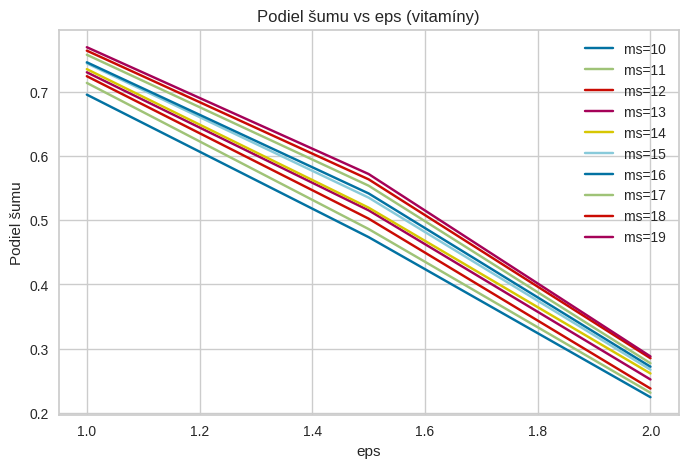

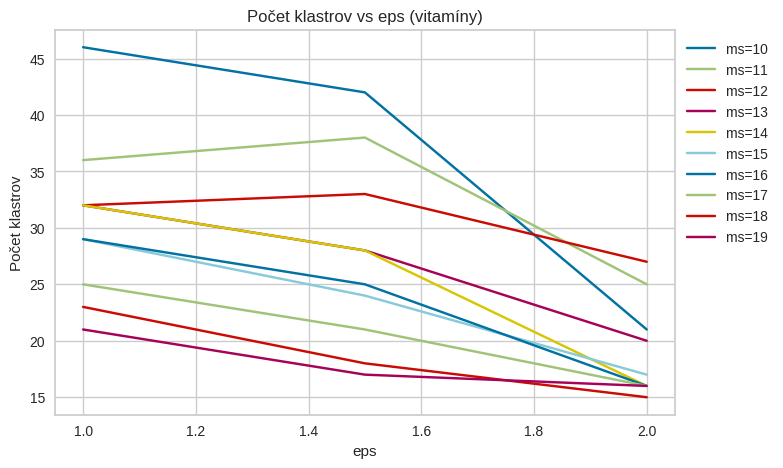

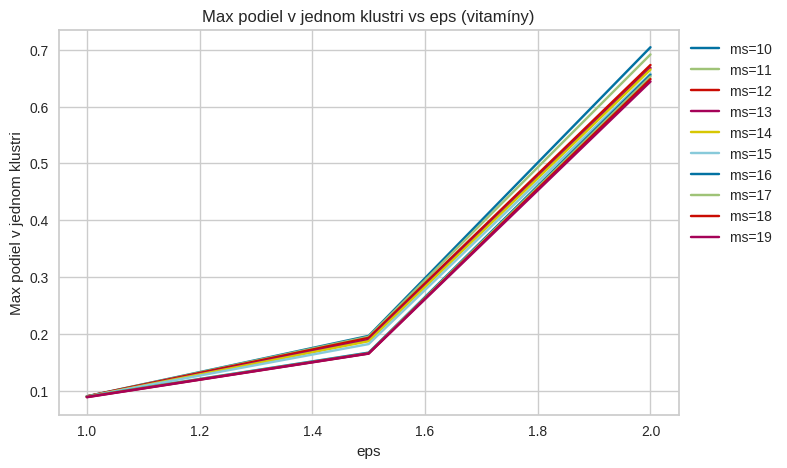

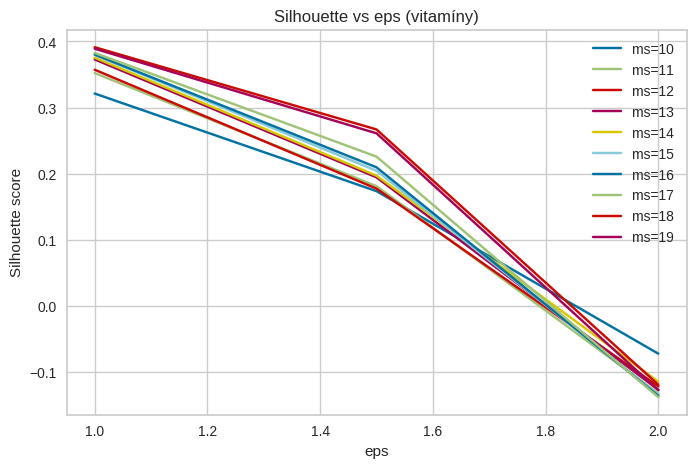

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# 1) Príprava vitamínových dát
X_vit = df_final[vit_cols].fillna(0).values

# 2) Transformácia a škálovanie
pt = PowerTransformer(method='yeo-johnson', standardize=False)
X_t = pt.fit_transform(X_vit)
X_scaled = StandardScaler().fit_transform(X_t)

# 3) Grid search
eps_values = np.arange(1, 2.5, 0.5)
D = X_scaled.shape[1]
min_samples_vals = range(10, 20)
n = len(X_scaled)

results = []
for eps in eps_values:
    for ms in min_samples_vals:
        labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(X_scaled)
        mask = labels != -1
        n_clusters = len(set(labels[mask]))
        noise_frac = np.mean(labels == -1)
        sizes = np.bincount(labels[labels >= 0])
        max_cluster_frac = sizes.max() / n if len(sizes) > 0 else 0
        sil = silhouette_score(X_scaled[mask], labels[mask]) if n_clusters >= 2 else np.nan
        results.append({
            'eps': eps,
            'min_samples': ms,
            'n_clusters': n_clusters,
            'noise_frac': noise_frac,
            'max_cluster_frac': max_cluster_frac,
            'silhouette': sil
        })

df_vit_res = pd.DataFrame(results)

# 4) Grafy
plt.figure(figsize=(8, 5))
for ms in min_samples_vals:
    sub = df_vit_res[df_vit_res['min_samples'] == ms]
    plt.plot(sub['eps'], sub['noise_frac'], label=f'ms={ms}')
plt.xlabel('eps')
plt.ylabel('Podiel šumu')
plt.title('Podiel šumu vs eps (vitamíny)')
plt.legend(bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
for ms in min_samples_vals:
    sub = df_vit_res[df_vit_res['min_samples'] == ms]
    plt.plot(sub['eps'], sub['n_clusters'], label=f'ms={ms}')
plt.xlabel('eps')
plt.ylabel('Počet klastrov')
plt.title('Počet klastrov vs eps (vitamíny)')
plt.legend(bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
for ms in min_samples_vals:
    sub = df_vit_res[df_vit_res['min_samples'] == ms]
    plt.plot(sub['eps'], sub['max_cluster_frac'], label=f'ms={ms}')
plt.xlabel('eps')
plt.ylabel('Max podiel v jednom klustri')
plt.title('Max podiel v jednom klustri vs eps (vitamíny)')
plt.legend(bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
for ms in min_samples_vals:
    sub = df_vit_res[df_vit_res['min_samples'] == ms]
    plt.plot(sub['eps'], sub['silhouette'], label=f'ms={ms}')
plt.xlabel('eps')
plt.ylabel('Silhouette score')
plt.title('Silhouette vs eps (vitamíny)')
plt.legend(bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()


Výpočet a následné klastrovanie vyšlo najlepšie pre **eps** = 1.8 a **min_samples** = 19

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

eps_value = 1.8
min_samples_value = 19

X = df_final[vit_cols].fillna(0).values

pt = PowerTransformer(method='yeo-johnson', standardize=False)
X_t = pt.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_t)

# Tréning DBSCAN
db = DBSCAN(eps=eps_value, min_samples=min_samples_value)
labels = db.fit_predict(X_scaled)
df_final['cluster_vit'] = labels

### Veľkosti klastrov

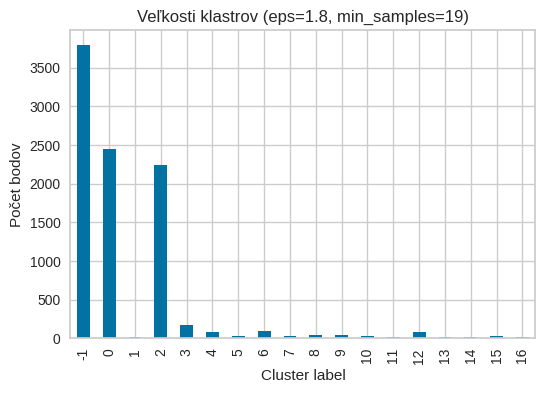

In [ ]:
counts = pd.Series(labels).value_counts().sort_index()
plt.figure(figsize=(6,4))
counts.plot(kind='bar')
plt.title(f'Veľkosti klastrov (eps={eps_value}, min_samples={min_samples_value})')
plt.xlabel('Cluster label')
plt.ylabel('Počet bodov')
plt.show()

### Štatistika klastrov

In [ ]:
counts = counts.rename_axis('cluster').reset_index(name='count')
counts['percent'] = (counts['count'] / counts['count'].sum() * 100).round(2)
print("\nVeľkosti klastrov a podiel:")
print(counts.to_string(index=False))


Veľkosti klastrov a podiel:
 cluster  count  percent
      -1   3795    41.24
       0   2447    26.59
       1     22     0.24
       2   2245    24.39
       3    171     1.86
       4     76     0.83
       5     28     0.30
       6     93     1.01
       7     24     0.26
       8     48     0.52
       9     38     0.41
      10     32     0.35
      11     22     0.24
      12     80     0.87
      13     22     0.24
      14     22     0.24
      15     25     0.27
      16     13     0.14


### Kvalitativne metriky (bez šumu)

In [ ]:
sil = silhouette_score(X_scaled[mask], labels[mask])
dbs = davies_bouldin_score(X_scaled[mask], labels[mask])
ch  = calinski_harabasz_score(X_scaled[mask], labels[mask])
print(f"\nSilhouette (bez šumu):       {sil:.3f}")
print(f"Davies–Bouldin (bez šumu):   {dbs:.3f}")
print(f"Calinski–Harabasz (bez šumu):{ch:.3f}")


Silhouette (bez šumu):       0.131
Davies–Bouldin (bez šumu):   1.236
Calinski–Harabasz (bez šumu):353.935


### Priemery a štandardné odchýlky

In [ ]:
profile = pd.DataFrame(X, columns=vit_cols)
profile['cluster_vit'] = labels
mean_prof = profile.groupby('cluster_vit').mean().round(2)
std_prof  = profile.groupby('cluster_vit').std().round(2)

print("\nPriemerné hodnoty príznakov v klastroch:")
print(mean_prof)
print("\nŠtandardné odchýlky príznakov v klastroch:")
print(std_prof)


Priemerné hodnoty príznakov v klastroch:
             Calcium_mg  Iron_mg  Magnesium_mg  Phosphorus_mg  Potassium_mg  \
cluster_vit                                                                   
-1               118.03     4.37         55.96         204.51        355.74   
 0                26.44     0.51         10.57          29.41        139.21   
 1               257.23     6.26         18.64         298.00         86.64   
 2                26.40     1.99         23.03         199.19        287.28   
 3                 0.02     2.75         18.66          82.11        125.92   
 4                89.57     1.41          8.26          57.37         97.57   
 5               339.14    21.76         47.21         195.61        209.39   
 6                21.49     0.67         29.58         218.67        339.19   
 7               146.71     3.47         15.08         147.21        180.67   
 8               735.88     0.40         28.21         529.88        130.77   
 9        

### 2D PCA vizualizácia ( bez šumu)

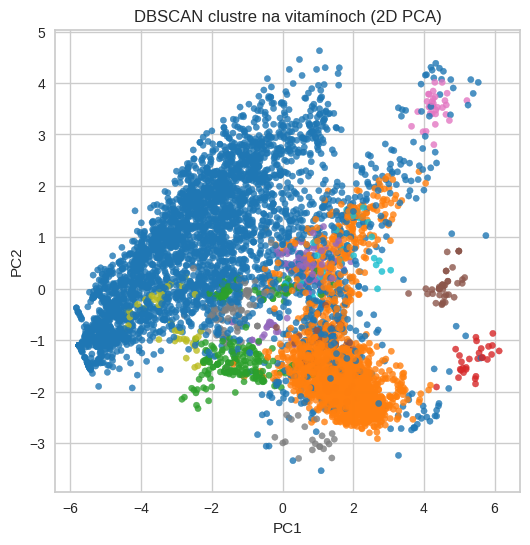

In [ ]:
pc2 = PCA(n_components=2).fit_transform(X_scaled)
plt.figure(figsize=(6,6))
plt.scatter(pc2[mask,0], pc2[mask,1], c=labels[mask], cmap='tab10', s=20, alpha=0.8)
plt.title('DBSCAN clustre na vitamínoch (2D PCA)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

### Ukážka položiek v každom klastri

In [ ]:
print("\nUkážka potravín v klastroch:")
for cid, grp in df_final.groupby('cluster_vit'):
    print(f"\nCluster {cid} (n={len(grp)}):")
    print(grp['Descrip'].head(50).to_list())


Ukážka potravín v klastroch:

Cluster -1 (n=3795):
["cereals rte kellogg's crunchy nut golden honey nut flakes", 'gogu leaves  green ', 'chrysanthemum garland ckd bld drnd wosalt', 'cookies choc crm covered biscuit stks', 'soup veg chick cnd prep w h2o lo na', 'bread wheat sprouted', 'dip tostitos salsa con queso med', "campbell's red  white chick alphabet soup cond", 'beef nz imp var meats  by-products liver ckd bld', 'cereals malt-o-meal choc prep w h2o wo salt', 'beans liq from stwd kidney bns', 'syrups sorghum', 'sunshine cheez-it scrabble jr crackers', 'snacks popcorn home-prepared oil-popped unsalted', 'soy sau made from soy (tamari)', 'strudel apple', 'ham sliced reg (approx 11 fat)', 'soup pea grn cnd prep w eq volume h2o', 'jowar', 'wheat flr white (industrial) 10 prot bleached enr', 'usda commodity bf patties wvpp frz ckd', 'snacks  brown rice chips', 'cereals crm of wheat reg 10 minute cooking dry', 'pepper black', 'granola bars soft coatd milk choc coating pnut butter', 's

### Hlavné clustre (spolu ≈ 92 % dát)

### Hlavné clustre (spolu ≈ 92 % dát)

#### Claster –1 (≈ 41 % dát) – “Zmiešaný šum”
- **Mikronutrientový profil:** stredne vysoký obsah Ca (≈ 118 mg), Fe (≈ 4,4 mg), Mg (≈ 56 mg), P (≈ 205 mg), K (≈ 356 mg), Na (≈ 420 mg); vitamíny v rôznych, spravidla nižších dávkach (VitC ≈ 11 mg, B-vitamíny ≈ 0,3–4 mg).  
- **Typické potraviny:** cereálie (raňajkové vločky, granola), zeleninové polievky a detské príkrmy, snacky a sušienky, pečivo, konzervy a polotovary.

#### Claster 0 (≈ 27 % dát) – “Polievky a zeleninové produkty”
- **Mikronutrientový profil:** nízky Ca (≈ 26 mg), Fe (≈ 0,5 mg), Mg (≈ 11 mg), P (≈ 29 mg), K (≈ 139 mg), Na (≈ 155 mg), VitC (≈ 14 mg), ostatné vitamíny veľmi nízko.  
- **Typické potraviny:** ochutené aj detské zeleninové polievky, konzervovaná zelenina, šťavy a omáčky.

#### Claster 2 (≈ 24 % dát) – “Mäso”
- **Mikronutrientový profil:** vysoký P (≈ 199 mg), Fe (≈ 2 mg), Mg (≈ 23 mg), K (≈ 287 mg), stredný Ca a Na.  
- **Typické potraviny:** hovädzie, bravčové, jahňacie a hydinové mäso vrátane spracovaných výrobkov (klobásy, paštéty).

---

### Stredne veľké špecializované clustre (< 2 % dát)

1. **Claster 3 (1,86 %) – Sušienky a krekry**  
2. **Claster 4 (0,83 %) – Tekuté detské výživy (RTF)**  
3. **Claster 5 (0,30 %) – Sladké cereálie (raňajkové mixy)**  
4. **Claster 6 (1,01 %) – Ryby a morské plody**  
5. **Claster 7 (0,26 %) – Snacky a sendvičové sušienky**  
6. **Claster 8 (0,52 %) – Syry (vysoký Ca, Na, P)**  
7. **Claster 9 (0,41 %) – Práškové detské výživy**  
8. **Claster 10 (0,35 %) – Strukoviny (sušené bôby, cícer)**  
9. **Claster 11 (0,24 %) – Rastlinné alternatívy mäsa**  
10. **Claster 12 (0,87 %) – Mliečne výrobky a pudingy**  
11. **Claster 13 (0,24 %) – Prémiové sendviče a pečivo**  
12. **Claster 14 (0,24 %) – Margaríny a tukové nátierky**  
13. **Claster 15 (0,27 %) – Pizza a fast-food výrobky**  
14. **Claster 16 (0,14 %) – Hotové cestoviny a zapekané syrové jedlá**  

---

* DBSCAN detegoval základné výživové segmenty (mäso, zelenina, mliečne produkty), ako aj špecializované „nutričné ostrovy“ (výživy, syry, ryby, strukoviny).
* 41 % dát bolo zaradených ako šum, čo opat poukazuje na uniformitu dat a nevhodnost DBSCANu pre tento konkretny pripad.


## Porovnání modelů

K-means má výhodu, že velikosti shluků jsou o něco více vyrovnané než u DBSCAN, ale shluky nejsou tak specializované jako u DBSCAN a některý shluk má více různorodý (např. nízkokalorický/ tekutý shluk byl dosti různorodý)

DBSCAN má zase velké množství malých specifických shluků a pár hodně velkých shluků. Zásadní nevýhodou u DBSCAN je, že na parametrech vytvářející obstojné shlukové rozdělení bylo velké množství dat označeno za outliery.

Převážně kvůli této nevýhodě velkého množství šumu se nám zdá být K-means jako lepší varianta pro naše data.

